# Data splitting 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import xml.etree.ElementTree as ET
from functions import *

## Old dataset

In [2]:
base_path = '/Users/leilapaolini/Documents/Data for project 2'
full_path = os.path.join(base_path, 'data.npy')
data = np.load(full_path, allow_pickle=True)

print(f"Data type: {type(data)}")
print(f"Data shape: {data.shape if hasattr(data, 'shape') else 'N/A'}")

Data type: <class 'numpy.ndarray'>
Data shape: (432765, 34)


In [3]:
df = pd.DataFrame(data, columns=['commune_1', 'commune_2', 'distance', 'GEM_FLAECH_X', 'pop_1', 'year_X',
                                 'GEM_FLAECH_y', 'pop_2', 'year_y', 'T_Mann', 'T_Frau', 'Etr_Total',
                                 'year', 'Accidents dégâts matériels',
                                 'Accidents avec dommages corporels', 'Morts', 'BFS_NUMMER',
                                 'GEM_FLAECH', 'ETNMOHNERZ', 'unemployment', 'gdp', 'T_Mann_2',
                                 'T_Frau_2', 'Etr_Total_2', 'year_2', 'Accidents dégâts matériels_2',
                                 'Accidents avec dommages corporels_2', 'Morts_2', 'BFS_NUMMER_2',
                                 'GEM_FLAECH_2', 'ETNMOHNERZ_2', 'unemployment_2', 'gdp_2', 'flow'])

In [4]:
print(df.head())

   commune_1  commune_2     distance  GEM_FLAECH_X  pop_1  year_X  \
0     3707.0     3668.0  4149.780273         817.0   44.0  2018.0   
1     3707.0     3668.0  4149.780273         817.0   44.0  2018.0   
2     3707.0     3668.0  4149.780273         817.0   46.0  2020.0   
3     3707.0     3668.0  4149.780273         817.0   46.0  2020.0   
4      661.0     2275.0  4989.176270         100.0   46.0  2020.0   

   GEM_FLAECH_y   pop_2  year_y  T_Mann  ...  year_2  \
0        1677.0  3111.0  2018.0   566.0  ...  2020.0   
1        1677.0  3217.0  2020.0   566.0  ...  2020.0   
2        1677.0  3217.0  2020.0   566.0  ...  2020.0   
3        1677.0  3111.0  2018.0   566.0  ...  2020.0   
4        2695.0  8168.0  2018.0  1561.0  ...  2018.0   

   Accidents dégâts matériels_2  Accidents avec dommages corporels_2  Morts_2  \
0                          20.0                                 21.0      0.0   
1                          20.0                                 21.0      0.0   
2    

### Geographical split 
We start by testing a geographical split, we identify a conton that will be the test set and train on all other cantons. For now I chose Bern because it contains roughly 1/9 of the swiss population and is a quite large canton with a big "hub" city but also smaller communes.

In [5]:
# first we need to map every commune to its canton using the bfs codes file
canton_bsf = pd.read_csv('/Users/leilapaolini/Documents/Data for project 2/bfscodes.csv')

print(canton_bsf.head())


   id_gde            name_gde  id_kant name_kant_fr name_kant_de
0       1     Aeugst am Albis        1       Zurich       Zürich
1       2  Affoltern am Albis        1       Zurich       Zürich
2       3          Bonstetten        1       Zurich       Zürich
3       4     Hausen am Albis        1       Zurich       Zürich
4       5            Hedingen        1       Zurich       Zürich


In [6]:
commune_to_canton_id = dict(zip(canton_bsf['id_gde'], canton_bsf['id_kant']))
commune_to_canton_name = dict(zip(canton_bsf['id_gde'], canton_bsf['name_kant_fr']))  

# Canton ID to Canton Code mapping
canton_id_to_code = {
    1: 'ZH',  # Zurich
    2: 'BE',  # Bern
    3: 'LU',  # Lucerne
    4: 'UR',  # Uri
    5: 'SZ',  # Schwyz
    6: 'OW',  # Obwalden
    7: 'NW',  # Nidwalden
    8: 'GL',  # Glarus
    9: 'ZG',  # Zug
    10: 'FR', # Fribourg
    11: 'SO', # Solothurn
    12: 'BS', # Basel-Stadt
    13: 'BL', # Basel-Landschaft
    14: 'SH', # Schaffhausen
    15: 'AR', # Appenzell Ausserrhoden
    16: 'AI', # Appenzell Innerrhoden
    17: 'SG', # St. Gallen
    18: 'GR', # Graubünden
    19: 'AG', # Aargau
    20: 'TG', # Thurgau
    21: 'TI', # Ticino
    22: 'VD', # Vaud
    23: 'VS', # Valais
    24: 'NE', # Neuchâtel
    25: 'GE', # Geneva
    26: 'JU'  # Jura
}

# we add canton info to dataframe
df['canton_id_1'] = df['commune_1'].map(commune_to_canton_id)
df['canton_id_2'] = df['commune_2'].map(commune_to_canton_id)

df['canton_code_1'] = df['canton_id_1'].map(canton_id_to_code)
df['canton_code_2'] = df['canton_id_2'].map(canton_id_to_code)


# checking for missing mappings
print("Missing canton mappings for commune_1:", df['canton_code_1'].isnull().sum())
print("Missing canton mappings for commune_2:", df['canton_code_2'].isnull().sum())

# showing canton distribution
print("\nOrigin canton distribution:")
print(df['canton_code_1'].value_counts().head(10))

print("\nDestination canton distribution:")
print(df['canton_code_2'].value_counts().head(10))

Missing canton mappings for commune_1: 6908
Missing canton mappings for commune_2: 3572

Origin canton distribution:
canton_code_1
AG    97258
ZH    87072
BE    68372
SO    37188
FR    25151
BL    24492
GR    12642
SZ    12000
SG    11516
TG    10102
Name: count, dtype: int64

Destination canton distribution:
canton_code_2
ZH    103548
AG     82196
BE     72808
SO     32390
BL     25476
FR     23129
ZG     15510
SG     12406
GR     11754
SZ      9698
Name: count, dtype: int64


In [ ]:
print(df.head())
# counting number of missing canton codes
missing_canton_1 = df['canton_code_1'].isnull().sum()
missing_canton_2 = df['canton_code_2'].isnull().sum()

   commune_1  commune_2     distance  GEM_FLAECH_X  pop_1  year_X  \
0     3707.0     3668.0  4149.780273         817.0   44.0  2018.0   
1     3707.0     3668.0  4149.780273         817.0   44.0  2018.0   
2     3707.0     3668.0  4149.780273         817.0   46.0  2020.0   
3     3707.0     3668.0  4149.780273         817.0   46.0  2020.0   
4      661.0     2275.0  4989.176270         100.0   46.0  2020.0   

   GEM_FLAECH_y   pop_2  year_y  T_Mann  ...  BFS_NUMMER_2  GEM_FLAECH_2  \
0        1677.0  3111.0  2018.0   566.0  ...        4045.0        1060.0   
1        1677.0  3217.0  2020.0   566.0  ...        4045.0        1060.0   
2        1677.0  3217.0  2020.0   566.0  ...        4045.0        1060.0   
3        1677.0  3111.0  2018.0   566.0  ...        4045.0        1060.0   
4        2695.0  8168.0  2018.0  1561.0  ...        6741.0        1168.0   

   ETNMOHNERZ_2  unemployment_2        gdp_2  flow  canton_id_1  canton_id_2  \
0       20852.0    12802.583333  44108.19224   6

Notice that there are NaN values and there is no symmetry in number of communes 1 and 2 in every canton. We need to get back on this, maybe i am not using the right year's communes

In [8]:
# for now lets remove rows with missing canton codes

df = df.dropna(subset=['canton_code_1', 'canton_code_2'])
print(df.head())

    commune_1  commune_2     distance  GEM_FLAECH_X  pop_1  year_X  \
16     3711.0     3668.0  2167.703369         202.0   53.0  2020.0   
17     3711.0     3668.0  2167.703369         202.0   53.0  2020.0   
18     3711.0     3668.0  2167.703369         202.0   53.0  2020.0   
19     3711.0     3668.0  2167.703369         202.0   53.0  2020.0   
20     3711.0     3668.0  2167.703369         202.0   53.0  2020.0   

    GEM_FLAECH_y   pop_2  year_y  T_Mann  ...  BFS_NUMMER_2  GEM_FLAECH_2  \
16        1677.0  3217.0  2020.0   421.0  ...        4045.0        1060.0   
17        1677.0  3217.0  2020.0   421.0  ...        4045.0        1060.0   
18        1677.0  3217.0  2020.0   421.0  ...        4045.0        1060.0   
19        1677.0  3111.0  2018.0   421.0  ...        4045.0        1060.0   
20        1677.0  3111.0  2018.0   421.0  ...        4045.0        1060.0   

    ETNMOHNERZ_2  unemployment_2        gdp_2  flow  canton_id_1  canton_id_2  \
16       20852.0    12802.583333  4

In [9]:
def strict_canton_split(df, test_canton_code='BE', test_canton_id=2):
    """
    Strict split: All flows whose origin or destination is in the Bern canton → test set
    """
    print(f"splitting with {test_canton_code} as test canton:")
    
    # Get all communes in chosen canton
    communes_list = canton_bsf[canton_bsf['id_kant'] == test_canton_id]['id_gde'].tolist()
    print(f"Number of communes in {test_canton_code}: {len(communes_list)}")
    
    # Train: flows where NEITHER origin NOR destination is in Bern
    train_mask = ~(df['commune_1'].isin(communes_list) | df['commune_2'].isin(communes_list))
    
    # Test: flows involving Bern
    test_df = df[~train_mask].copy()
    train_df = df[train_mask].copy()
    
    # Verify NO Bern communes in train
    train_communes = set(train_df['commune_1'].unique()).union(set(train_df['commune_2'].unique()))
    bern_communes_set = set(communes_list)
    overlap = train_communes.intersection(bern_communes_set)
    
    
    print(f"Total flows: {len(df):,}")
    print(f"Train size: {len(train_df):,} rows ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Test size:  {len(test_df):,} rows ({len(test_df)/len(df)*100:.1f}%)")
    print(f"Test canton: {test_canton_code} (ID: {test_canton_id})")
    print(f"Bern communes in train: {len(overlap)} (should be 0)")
    
    assert len(overlap) == 0, f"Bern communes found in train set: {overlap}"
    
    return train_df, test_df

# Split with Bern as test canton
train_df, test_df = strict_canton_split(df, test_canton_code='BE', test_canton_id=2)

splitting with BE as test canton:
Number of communes in BE: 335
Total flows: 422,633
Train size: 337,473 rows (79.9%)
Test size:  85,160 rows (20.1%)
Test canton: BE (ID: 2)
Bern communes in train: 0 (should be 0)


In [10]:
train_zero = (train_df['flow'] == 0).sum()
test_zero = (test_df['flow'] == 0).sum()
print(f"\nZero flows in train set: {train_zero} ({train_zero/len(train_df)*100:.2f}%)")
print(f"Zero flows in test set: {test_zero} ({test_zero/len(test_df)*100:.2f}%)")


Zero flows in train set: 0 (0.00%)
Zero flows in test set: 0 (0.00%)


We need to add zero flows!! 

### Training and testing on split

In [11]:
import xgboost as xgb

In [12]:
# Identify feature columns (exclude flow and identifier columns)
exclude_cols = ['flow', 'commune_1', 'commune_2', 'canton_id_1', 'canton_id_2', 
                'canton_code_1', 'canton_code_2', 'pair_id', 'flow_log']
    
# Only include columns that exist in the dataframe
exclude_cols = [col for col in exclude_cols if col in train_df.columns]
    
feature_cols = [col for col in train_df.columns if col not in exclude_cols and col != 'flow']
    
print(f"Number of features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")
    
# Separate features and target
X_train = train_df[feature_cols].values
y_train = train_df['flow'].values
    
X_test = test_df[feature_cols].values
y_test = test_df['flow'].values
    
print(f"\nData shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}, y_test: {y_test.shape}")




Number of features: 31
Feature columns: ['distance', 'GEM_FLAECH_X', 'pop_1', 'year_X', 'GEM_FLAECH_y', 'pop_2', 'year_y', 'T_Mann', 'T_Frau', 'Etr_Total', 'year', 'Accidents dégâts matériels', 'Accidents avec dommages corporels', 'Morts', 'BFS_NUMMER', 'GEM_FLAECH', 'ETNMOHNERZ', 'unemployment', 'gdp', 'T_Mann_2', 'T_Frau_2', 'Etr_Total_2', 'year_2', 'Accidents dégâts matériels_2', 'Accidents avec dommages corporels_2', 'Morts_2', 'BFS_NUMMER_2', 'GEM_FLAECH_2', 'ETNMOHNERZ_2', 'unemployment_2', 'gdp_2']

Data shapes:
X_train: (337473, 31), y_train: (337473,)
X_test:  (85160, 31), y_test: (85160,)


Training regression model...

Regression Results:
  MSE: 20230.47
  RMSE: 142.23
  R²: 0.3386
Pearson Correlation: 0.603


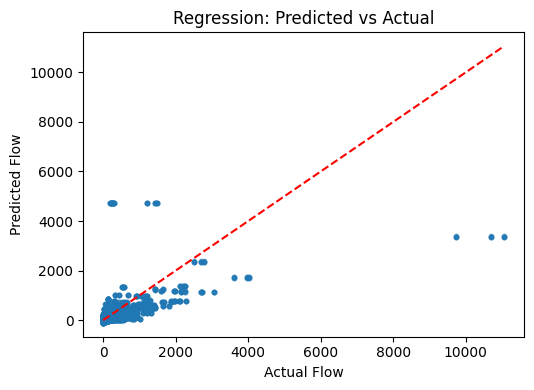

In [13]:
reg_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

print("Training regression model...")
reg_model.fit(X_train, y_train)

# Predict
y_pred_reg = reg_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_reg)
correlation = np.corrcoef(y_test, y_pred_reg)[0, 1]

print(f"\nRegression Results:")
print(f"  MSE: {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.4f}")
print(f"Pearson Correlation: {correlation:.3f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_reg, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Flow')
plt.ylabel('Predicted Flow')
plt.title('Regression: Predicted vs Actual')

plt.tight_layout()
plt.show()

In [33]:
error = y_test - y_pred_reg
abs_errors = np.abs(error)

top_10_indices = np.argsort(abs_errors)[-20:][::-1]

print("Top 10 data rows with highest absolute errors:")
print("=" * 80)

# First, let's see what columns are in test_df
print(f"test_df columns: {test_df.columns.tolist()}")
print(f"Number of rows in test_df: {len(test_df)}")
print(f"Indices to access: {top_10_indices}")
print("=" * 80)

for i, idx in enumerate(top_10_indices, 1):
    actual = y_test[idx]
    predicted = y_pred_reg[idx]
    abs_error = abs_errors[idx]
    
    print(f"\n{i} - Row index: {idx}")
    print(f"Actual flow: {actual:.2f}, Predicted: {predicted:.2f}, Abs Error: {abs_error:.2f}")
    
    if idx < len(test_df):
        # Get the row
        row = test_df.iloc[idx]
        
        # Try to use meaningful column names if they exist
        if 'commune_1' in test_df.columns and 'commune_2' in test_df.columns and 'year' in test_df.columns:
            print(f"Origin city (commune_1): {row['commune_1']}, "
                  f"Destination city (commune_2): {row['commune_2']}, "
                  f"Year: {row['year']}",
                  f"Distance: {row['distance']}")
        else:
            # Use column indices with descriptive labels
            print(f"Origin city (col 0): {row.iloc[0]}, "
                  f"Destination city (col 1): {row.iloc[1]}, "
                  f"Year (col 5): {row.iloc[5]}")
    else:
        print(f"Warning: Index {idx} is out of bounds for test_df with {len(test_df)} rows")


Top 10 data rows with highest absolute errors:
test_df columns: ['commune_1', 'commune_2', 'distance', 'GEM_FLAECH_X', 'pop_1', 'year_X', 'GEM_FLAECH_y', 'pop_2', 'year_y', 'T_Mann', 'T_Frau', 'Etr_Total', 'year', 'Accidents dégâts matériels', 'Accidents avec dommages corporels', 'Morts', 'BFS_NUMMER', 'GEM_FLAECH', 'ETNMOHNERZ', 'unemployment', 'gdp', 'T_Mann_2', 'T_Frau_2', 'Etr_Total_2', 'year_2', 'Accidents dégâts matériels_2', 'Accidents avec dommages corporels_2', 'Morts_2', 'BFS_NUMMER_2', 'GEM_FLAECH_2', 'ETNMOHNERZ_2', 'unemployment_2', 'gdp_2', 'flow', 'canton_id_1', 'canton_id_2', 'canton_code_1', 'canton_code_2']
Number of rows in test_df: 85160
Indices to access: [79311 79314 79308 79305 79312 79315 79309 79306 79310 79313 79307 79304
 79130 79133 79124 79127 80085 80082 80076 80079]

1 - Row index: 79311
Actual flow: 11053.00, Predicted: 3353.45, Abs Error: 7699.55
Origin city (commune_1): 355.0, Destination city (commune_2): 351.0, Year: 2018.0 Distance: 4856.08837890625

Probably poor results are due to the fact that there are few very large flows


After filtering flows > 6000:
splitting with BE as test canton:
Number of communes in BE: 335
Total flows: 422,601
Train size: 337,453 rows (79.9%)
Test size:  85,148 rows (20.1%)
Test canton: BE (ID: 2)
Bern communes in train: 0 (should be 0)
Training regression model filtered sets ...

Regression Results:
  MSE: 5886.29
  RMSE: 76.72
  R²: 0.6108
Pearson Correlation: 0.783


Text(0.5, 1.0, 'Regression: Predicted vs Actual')

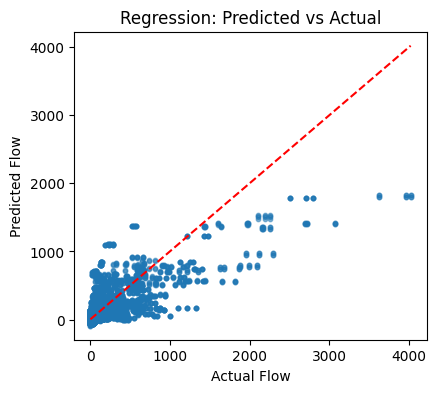

In [ ]:
# lets try to remove flows that are higher than 6000
flow_threshold = 6000
df_filtered = df[df['flow'] <= flow_threshold]
print(f"After filtering flows > {flow_threshold}:")
train_df_filt, test_df_filt = strict_canton_split(df_filtered, test_canton_code='BE', test_canton_id=2)
X_train_filt = train_df_filt[feature_cols].values
y_train_filt = train_df_filt['flow'].values
X_test_filt = test_df_filt[feature_cols].values
y_test_filt = test_df_filt['flow'].values

print("Training regression model filtered sets ...")
reg_model.fit(X_train_filt, y_train_filt)

# Predict
y_pred_filt = reg_model.predict(X_test_filt)

# Evaluate
mse = mean_squared_error(y_test_filt, y_pred_filt)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_filt, y_pred_filt)
correlation = np.corrcoef(y_test_filt, y_pred_filt)[0, 1]

print(f"\nRegression Results:")
print(f"  MSE: {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.4f}")
print(f"Pearson Correlation: {correlation:.3f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test_filt, y_pred_filt, alpha=0.5, s=10)
plt.plot([y_test_filt.min(), y_test_filt.max()], [y_test_filt.min(), y_test_filt.max()], 'r--')
plt.xlabel('Actual Flow')
plt.ylabel('Predicted Flow')
plt.title('Regression: Predicted vs Actual')


In [15]:

# Apply log transformation
y_train_log = np.log1p(y_train)  # log(1 + y)
y_test_log = np.log1p(y_test)

# Train new model
reg_model_log = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

print("Training on log-transformed flows...")
reg_model_log.fit(X_train, y_train_log)

# Predict and transform back
y_pred_log = reg_model_log.predict(X_test)
y_pred_exp = np.expm1(y_pred_log)  # Convert back to original scale

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_exp))
r2_log = r2_score(y_test, y_pred_exp)
corr_log = np.corrcoef(y_test, y_pred_exp)[0, 1]

print(f"After Log Transformation:")
print(f"  RMSE: {rmse_log:.2f} (was {142.23})")
print(f"  R²:   {r2_log:.4f} (was {0.3386})")
print(f"  Correlation: {corr_log:.3f} (was {0.603})")

Training on log-transformed flows...
After Log Transformation:
  RMSE: 137.82 (was 142.23)
  R²:   0.3790 (was 0.3386)
  Correlation: 0.671 (was 0.603)


In [16]:
# Better parameter set for spatial data
reg_model_optimized = xgb.XGBRegressor(
    n_estimators=1500,           # More trees
    max_depth=8,                 # Deeper trees for complex patterns
    learning_rate=0.05,          # Slower learning
    subsample=0.8,               # Prevent overfitting
    colsample_bytree=0.8,        # Feature subsampling
    reg_alpha=0.1,               # L1 regularization
    reg_lambda=1.0,              # L2 regularization
    min_child_weight=5,          # Conservative splitting
    gamma=0.1,                   # Minimum loss reduction
    random_state=42,
    n_jobs=-1
)

# Train with log-transformed target AND enhanced features
print("Training optimized model...")
reg_model_optimized.fit(X_train, y_train_log)

# Predict
y_pred_opt_log = reg_model_optimized.predict(X_test)
y_pred_opt = np.expm1(y_pred_opt_log)

# Evaluate
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)
corr_opt = np.corrcoef(y_test, y_pred_opt)[0, 1]

print(f"New Model Results:")
print(f"  RMSE: {rmse_opt:.2f}")
print(f"  R²:   {r2_opt:.4f}")
print(f"  Correlation: {corr_opt:.3f}")

Training optimized model...
New Model Results:
  RMSE: 151.42
  R²:   0.2504
  Correlation: 0.616


We try gradient boosting too

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

In [18]:
gbr = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.1,
    n_estimators=300,
    max_depth=6,               # Deeper trees like XGBoost
    min_samples_split=2,       # Like XGBoost defaults
    min_samples_leaf=1,
    random_state=42
)

gbr.fit(X_train, y_train)

pred_y_gbr = gbr.predict(X_test)

mse = mean_squared_error(y_test, pred_y_gbr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_y_gbr)
correlation = np.corrcoef(y_test, pred_y_gbr)[0, 1]

print(f"\nRegression Results:")
print(f"  MSE: {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.4f}")
print(f"Pearson Correlation: {correlation:.3f}")

KeyboardInterrupt: 

In [ ]:
gbr.fit(X_train, y_train_log)

pred_y_gbr = gbr.predict(X_test)


mse = mean_squared_error(y_test, pred_y_gbr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_y_gbr)
correlation = np.corrcoef(y_test, pred_y_gbr)[0, 1]

print(f"\nRegression Results:")
print(f"  MSE: {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.4f}")
print(f"Pearson Correlation: {correlation:.3f}")


Regression Results:
  MSE: 31648.09
  RMSE: 177.90
  R²: -0.0347
Pearson Correlation: 0.424


In [ ]:
mse = mean_squared_error(y_test_log, pred_y_gbr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_log, pred_y_gbr)
correlation = np.corrcoef(y_test_log, pred_y_gbr)[0, 1]

print(f"\nRegression Results:")
print(f"  MSE: {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.4f}")
print(f"Pearson Correlation: {correlation:.3f}")


Regression Results:
  MSE: 0.52
  RMSE: 0.72
  R²: 0.4690
Pearson Correlation: 0.721


## New dataset

In [3]:
base_path = '/Users/leilapaolini/Documents/Data for project 2'
full_path = os.path.join(base_path, 'data_y2.npy')
data_new = np.load(full_path, allow_pickle=True)

print(f"Data type: {type(data_new)}")
print(f"Data shape: {data_new.shape if hasattr(data_new, 'shape') else 'N/A'}")

Data type: <class 'numpy.ndarray'>
Data shape: (19237044, 37)


In [4]:
df_new = pd.DataFrame(data_new, columns=['commune_1', 'commune_2', 'distance', 'year', 'pop_1', 'pop_2',
       'T_Mann', 'T_Frau', 'Etr_Total', 'Accidents dégâts matériels',
       'Accidents avec dommages corporels', 'Morts', 'BFS_NUMMER',
       'GEM_FLAECH', 'EINWOHNERZ', '0-25', '25-65', '65+', 'canton_code',
       'unemployment', 'gdp', 'T_Mann_2', 'T_Frau_2', 'Etr_Total_2',
       'Accidents dégâts matériels_2', 'Accidents avec dommages corporels_2',
       'Morts_2', 'BFS_NUMMER_2', 'GEM_FLAECH_2', 'EINWOHNERZ_2', '0-25_2',
       '25-65_2', '65+_2', 'canton_code_2', 'unemployment_2', 'gdp_2', 'flow'])

df_new.head()

print(df_new['BFS_NUMMER'].nunique())

2197


In [5]:
to_remove = ['commune_1', 'commune_2', 'year', 'BFS_NUMMER', 'canton_code','BFS_NUMMER_2', 'canton_code_2', 'flow']

to_keep = [col for col in df_new.columns if col not in to_remove]

In [6]:
def canton_split(df, canton_ids=[2]):
    """
    Strict split: All flows whose origin OR destination is in the specified canton → test set
    """
    print(f"Splitting with canton {canton_ids} as test set:")
    # test: flows are either thein origin or their destination in the chosen canton 
    # train: flows where neither origin or destination is in chosen canton
    test_mask = (df['canton_code'].isin(canton_ids)) | (df['canton_code_2'].isin(canton_ids)) # TODO check this line
    train_mask = ~test_mask
    
    # splitting the data
    test_df = df[test_mask].copy()
    train_df = df[train_mask].copy()

    # we verify no flows involving the test canton are in train set
    train_has_test_canton = train_df[
        (train_df['canton_code'].isin(canton_ids)) | 
        (train_df['canton_code_2'].isin(canton_ids))
    ]
    
    print(f"Total flows: {len(df):,}")
    print(f"Train size: {len(train_df):,} rows ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Test size: {len(test_df):,} rows ({len(test_df)/len(df)*100:.1f}%)")
    print(f"Test cantons: {canton_ids}")
    print(f"Flows with test canton in train set: {len(train_has_test_canton)} (should be 0)")
    
    assert len(train_has_test_canton) == 0, \
        f"{len(train_has_test_canton)} flows involving cantons {canton_ids} found in train set!"
    
    # checking data is symmetric between destination and orignin
    print(f"Verification:")
    print(f"Unique communes in train (origin): {train_df['commune_1'].nunique()}")
    print(f"Unique communes in train (destination): {train_df['commune_2'].nunique()}")
    print(f"Unique communes in test (origin): {test_df['commune_1'].nunique()}")
    print(f"Unique communes in test (destination): {test_df['commune_2'].nunique()}")
    print(f"There are {test_df['commune_1'].nunique() - train_df['commune_1'].nunique()} communes in canton {canton_ids}")

    return train_df, test_df

train_df_new, test_df_new = canton_split(df_new, canton_ids=[2])

Splitting with canton [2] as test set:
Total flows: 19,237,044
Train size: 13,712,244 rows (71.3%)
Test size: 5,524,800 rows (28.7%)
Test cantons: [2]
Flows with test canton in train set: 0 (should be 0)
Verification:
Unique communes in train (origin): 1855
Unique communes in train (destination): 1855
Unique communes in test (origin): 2197
Unique communes in test (destination): 2197
There are 342 communes in canton [2]


In [7]:
def class_imbalance_check(train_df, test_df):
    """
    Check for class imbalance in train and test sets after canton split.
    """
    print(f"Class Imbalance Check :")
    train_zero = (train_df['flow'] == 0).sum()
    test_zero = (test_df['flow'] == 0).sum()
    print(f"Zero flows in train set: {train_zero} ({train_zero/len(train_df)*100:.2f}%)")
    print(f"Zero flows in test set: {test_zero} ({test_zero/len(test_df)*100:.2f}%)")

class_imbalance_check(train_df_new, test_df_new)

Class Imbalance Check :
Zero flows in train set: 13502383 (98.47%)
Zero flows in test set: 5483554 (99.25%)


In [8]:
#for canton_id in range(1, 27):
#    print(f"\n--- Splitting with canton ID {canton_id} ---")
#    train_df_canton, test_df_canton = canton_split(df_new, canton_id=canton_id)
#    class_imbalance_check(train_df_canton, test_df_canton)

In [9]:
def handle_class_imbalance(df_train, zero_drop_ratio=0.2, random_state=37):
    """
    Drop a specified percentage of zero flows.
    
    Parameters:
    -----------
    df_train : DataFrame
        Training data with 'flow' column
    zero_drop_ratio : float (0-1)
        Percentage of zero flows to drop (e.g., 0.5 = drop 50% of zeros)
    random_state : int
        Random seed for reproducibility
    """
    np.random.seed(random_state)
    
    zero_mask = df_train['flow'] == 0
    non_zero_mask = df_train['flow'] > 0
    
    zero_df = df_train[zero_mask]
    
    non_zero_df = df_train[non_zero_mask]
    
    # how many zeros to keep
    n_zeros_keep = int(len(zero_df) * (1 - zero_drop_ratio))
    
    print(f"\nDropping {zero_drop_ratio*100:.0f}% of zeros in training data")
    print(f"Keeping {n_zeros_keep:,} of {len(zero_df):,} zero flows")    
    # Sample zero flows
    zero_sample = zero_df.sample(n=n_zeros_keep, random_state=random_state)
    
    # Combine and shuffle
    balanced_df = pd.concat([non_zero_df, zero_sample], ignore_index=True)
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return balanced_df


balanced_train_df = handle_class_imbalance(train_df_new, 0.2, random_state=37)
class_imbalance_check(balanced_train_df, test_df_new)



Dropping 20% of zeros in training data
Keeping 10,801,906 of 13,502,383 zero flows
Class Imbalance Check :
Zero flows in train set: 10801906 (98.09%)
Zero flows in test set: 5483554 (99.25%)


In [10]:
def classification_fct(y_data, threshold=0):
    print("Flow reclassified as 1: flow present, 0: no flow")
    return (y_data > threshold).astype(int)

In [11]:
def build_train_test_sets(dataframe, canton_ids=[2], zero_drop_ratio=0.2, random_state=37, features=to_remove, classify = False):
    """ Final function to build train and test sets 
    Args:
        dataframe: full dataframe
        canton_id: canton to use as test set
        zero_drop_ratio: percentage of zero flows to drop from training set
        random_state: random seed for reproducibility
        to_remove: list of columns to remove from features (for example IDs and years)
    Returns:
        X_train, y_train, X_test, y_test
       """
    to_keep = [col for col in dataframe.columns if col not in to_remove]

    train_df, test_df = canton_split(dataframe, canton_ids=canton_ids)
    balanced_train_df = handle_class_imbalance(train_df, zero_drop_ratio, random_state)
    
    if classify == True:
        y_train = classification_fct(balanced_train_df['flow'].copy())
        y_test = classification_fct(test_df['flow'].copy())
    
    else: 
        y_train = balanced_train_df['flow'].copy()
        y_test = test_df['flow'].copy()

    X_train = balanced_train_df[to_keep].copy()

    X_test = test_df[to_keep].copy()
    
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = build_train_test_sets(
    df_new, 
    canton_ids=[2], 
    zero_drop_ratio=0.2, 
    random_state=37, 
    features=to_remove
)
print(f"\nFinal train/test sets:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}, y_test: {y_test.shape}")


Splitting with canton [2] as test set:
Total flows: 19,237,044
Train size: 13,712,244 rows (71.3%)
Test size: 5,524,800 rows (28.7%)
Test cantons: [2]
Flows with test canton in train set: 0 (should be 0)
Verification:
Unique communes in train (origin): 1855
Unique communes in train (destination): 1855
Unique communes in test (origin): 2197
Unique communes in test (destination): 2197
There are 342 communes in canton [2]

Dropping 20% of zeros in training data
Keeping 10,801,906 of 13,502,383 zero flows

Final train/test sets:
X_train: (11011767, 29), y_train: (11011767,)
X_test:  (5524800, 29), y_test: (5524800,)


In [12]:
def kfold_split(X_train, k_splits = 5, k_canton_ids=[]):
    """ Function to perform k-fold splitting on training data
    Args:
        X_train: training features
        k_splits: number of folds
        k_canton_ids: list of canton IDs to use for each fold (length must be k_splits)
    Returns:
        folds: list of k elements, each is a tuple (train_indices, test_indices, test_canton_id)
        where test_indices are indices of validation set for that fold that correspond to flows involving the canton with id test_canton_id
        and train_indices are indices of training set for that fold
    """

    folds = []

    cantons = X_train['canton_code'].unique()
    # if the list is empty we randomly select k canton ids
    if k_canton_ids == []:
        k_canton_ids = np.random.choice(cantons, size=k_splits, replace=False).tolist()
    
    if len(k_canton_ids) != k_splits:
        raise ValueError(f"Length of k_canton_ids ({len(k_canton_ids)}) must be equal to k_splits ({k_splits})")
    
    if len(k_canton_ids) >= len(cantons):
        raise ValueError(f"The number of chosen cantons ({len(k_canton_ids)}) must be less than the number of available cantons ({len(cantons)})")

    # we check that all canton ids are in the training set
    for canton_id in k_canton_ids:
        if canton_id not in cantons:
            raise ValueError(f"Canton ID {canton_id} is not in the training set! Choose from: {cantons}")

    # perform the k-fold split  
    for i, canton_id in enumerate(k_canton_ids):
        # Get test indices: flows where EITHER origin OR destination is in the test canton
        test_indices = X_train[
            (X_train['canton_code'] == canton_id) | 
            (X_train['canton_code_2'] == canton_id)
        ].index.tolist()
        
        # Get train indices: all other flows
        train_indices = X_train.index.difference(test_indices).tolist()
        
        # Create the fold
        nth_fold = (train_indices, test_indices, canton_id)
        folds.append(nth_fold)
        
        print(f"Fold {i+1}/{k_splits}: Canton {canton_id}")
        print(f"  Train samples: {len(train_indices):,}")
        print(f"  Test samples: {len(test_indices):,}")
        print(f"  Test ratio: {len(test_indices)/len(X_train):.1%}")
    
    return folds

In [13]:
X_train.head()

,distance,pop_1,pop_2,T_Mann,T_Frau,Etr_Total,Accidents dégâts matériels,Accidents avec dommages corporels,Morts,GEM_FLAECH,...,Accidents dégâts matériels_2,Accidents avec dommages corporels_2,Morts_2,GEM_FLAECH_2,EINWOHNERZ_2,0-25_2,25-65_2,65+_2,unemployment_2,gdp_2
0,79640.516411,4448.0,1582.0,2380.0,2196.0,286.0,36.0,8.0,0.0,1773.0,...,0.0,4.0,0.0,568.0,1582.0,349.0,933.0,367.0,12802.583333,44108.19224
1,198108.603381,992.0,8977.0,478.0,520.0,88.0,0.0,4.0,0.0,447.0,...,19.0,17.0,0.0,885.0,8977.0,2302.0,4807.0,2164.0,4274.250000,15320.30848
2,46818.569137,2215.0,6417.0,1078.0,1137.0,134.0,28.0,4.0,0.0,674.0,...,26.0,15.0,0.0,754.0,6340.0,1797.0,3543.0,1246.0,5531.750000,38071.56852
3,170128.566880,867.0,199.0,451.0,453.0,77.0,3.0,4.0,0.0,599.0,...,3.0,0.0,0.0,3772.0,199.0,23.0,99.0,83.0,2142.250000,14627.09554
4,96717.915568,1048.0,437.0,538.0,510.0,33.0,1.0,0.0,0.0,1816.0,...,2.0,0.0,0.0,293.0,411.0,139.0,240.0,65.0,3983.250000,27792.86656


In [14]:
def build_train_test_folds(dataframe, canton_ids=[2], zero_drop_ratio=0.2, random_state=37, features=to_remove, k_folds = 5 ,folds_ids=[]):
    """ Final function to build train and test sets 
    Args:
        dataframe: full dataframe
        canton_id: canton to use as test set
        zero_drop_ratio: percentage of zero flows to drop from training set
        random_state: random seed for reproducibility
        to_remove: list of columns to remove from features (for example IDs and years)
    Returns:
        X_train, y_train, X_test, y_test
       """
    to_keep = [col for col in dataframe.columns if col not in to_remove]

    train_df, test_df = canton_split(dataframe, canton_ids=canton_ids)
    balanced_train_df = handle_class_imbalance(train_df, zero_drop_ratio, random_state)

    folds = kfold_split(balanced_train_df, k_splits=k_folds, k_canton_ids=folds_ids)

    y_train = balanced_train_df['flow'].copy()
    X_train = balanced_train_df[to_keep].copy()

    y_test = test_df['flow'].copy()
    X_test = test_df[to_keep].copy()
    
    return X_train, y_train, X_test, y_test, folds

In [15]:
X_train, y_train, X_test, y_test, folds = build_train_test_folds(
    df_new, 
    canton_ids=[2], 
    zero_drop_ratio=0.2, 
    random_state=37, 
    features=to_remove,
    k_folds=5,
    folds_ids=[1, 7, 3, 4, 5]
)


Splitting with canton [2] as test set:
Total flows: 19,237,044
Train size: 13,712,244 rows (71.3%)
Test size: 5,524,800 rows (28.7%)
Test cantons: [2]
Flows with test canton in train set: 0 (should be 0)
Verification:
Unique communes in train (origin): 1855
Unique communes in train (destination): 1855
Unique communes in test (origin): 2197
Unique communes in test (destination): 2197
There are 342 communes in canton [2]

Dropping 20% of zeros in training data
Keeping 10,801,906 of 13,502,383 zero flows
Fold 1/5: Canton 1
  Train samples: 9,177,724
  Test samples: 1,834,043
  Test ratio: 16.7%
Fold 2/5: Canton 7
  Train samples: 10,881,487
  Test samples: 130,280
  Test ratio: 1.2%
Fold 3/5: Canton 3
  Train samples: 10,057,619
  Test samples: 954,148
  Test ratio: 8.7%
Fold 4/5: Canton 4
  Train samples: 10,775,475
  Test samples: 236,292
  Test ratio: 2.1%
Fold 5/5: Canton 5
  Train samples: 10,657,716
  Test samples: 354,051
  Test ratio: 3.2%


In [19]:
def build_train_test_val(dataframe, test_canton_ids=[2], val_canton_ids=[3], zero_drop_ratio=0.2, random_state=37, features=to_remove):
    """ Final function to build train, validation and test sets 
    Args:
        dataframe: full dataframe
        test_canton_ids: list of canton IDs to use as test set
        val_canton_ids: list of canton IDs to use as validation set
        zero_drop_ratio: percentage of zero flows to drop from training set
        random_state: random seed for reproducibility
        to_remove: list of columns to remove from features (for example IDs and years)
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test
       """
    

    unique_years = sorted(dataframe['year'].unique())
    for year_val in unique_years:
        col_name = f'year_{year_val}'
        dataframe[col_name] = (dataframe['year'] == year_val).astype(int)
        
    # Remove the original 'year' column from features to keep
    if 'year' not in features:
        features.append('year')
    

    to_keep = [col for col in dataframe.columns if col not in to_remove]

    train_df, test_df = canton_split(dataframe, canton_ids=test_canton_ids)
    train_df, val_df = canton_split(train_df, canton_ids=val_canton_ids)
    
    balanced_train_df = handle_class_imbalance(train_df, zero_drop_ratio, random_state)
    
    y_train = balanced_train_df['flow'].copy()
    X_train = balanced_train_df[to_keep].copy()

    y_val = val_df['flow'].copy()
    X_val = val_df[to_keep].copy()
    
    y_test = test_df['flow'].copy()
    X_test = test_df[to_keep].copy()
    
    return X_train, y_train, X_test, y_test, X_val, y_val

In [20]:
X_train, y_train, X_test, y_test, X_val, y_val = build_train_test_val(
    df_new, 
    test_canton_ids=[2], 
    val_canton_ids=[3], 
    zero_drop_ratio=0.2, 
    random_state=37, 
    features=to_remove
)
print(f"\nFinal train/val/test sets:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

Splitting with canton [2] as test set:
Total flows: 19,237,044
Train size: 13,712,244 rows (71.3%)
Test size: 5,524,800 rows (28.7%)
Test cantons: [2]
Flows with test canton in train set: 0 (should be 0)
Verification:
Unique communes in train (origin): 1855
Unique communes in train (destination): 1855
Unique communes in test (origin): 2197
Unique communes in test (destination): 2197
There are 342 communes in canton [2]
Splitting with canton [3] as test set:
Total flows: 13,712,244
Train size: 12,524,556 rows (91.3%)
Test size: 1,187,688 rows (8.7%)
Test cantons: [3]
Flows with test canton in train set: 0 (should be 0)
Verification:
Unique communes in train (origin): 1773
Unique communes in train (destination): 1773
Unique communes in test (origin): 1855
Unique communes in test (destination): 1855
There are 82 communes in canton [3]

Dropping 20% of zeros in training data
Keeping 9,866,779 of 12,333,474 zero flows

Final train/val/test sets:
X_train: (10057861, 31), y_train: (10057861,)

In [17]:
print("Whole dataset stats:")
print(f"Total rows: {len(df_new):,}")
print(f"Flows > 0: {(df_new['flow'] > 0).sum():,} ({(df_new['flow'] > 0).mean():.1%})")
print(f"Average flow: {df_new['flow'].mean():.2f}")
print(f"Average distance: {df_new['distance'].mean():.2f} km")
print(f"Unique cantons: {df_new['canton_code'].nunique()}")
print(f"GDP mean: {df_new['gdp'].mean():.0f}")
print(f"GDP std: {df_new['gdp'].std():.0f}")

print("\n" + "="*80)
print("PER CANTON STATISTICS")
print("="*80)

# Get all unique canton codes
unique_cantons = sorted(df_new['canton_code'].dropna().unique())

# Prepare canton stats for later summary
canton_stats_list = []

for i, canton in enumerate(unique_cantons, 1):
    # Get all rows involving this canton (either as origin OR destination)
    canton_mask = (df_new['canton_code'] == canton) | (df_new['canton_code_2'] == canton)
    canton_data = df_new[canton_mask]
    
    if len(canton_data) == 0:
        continue
    
    # Calculate statistics
    total_flows_involving = len(canton_data)
    percentage_of_total = (total_flows_involving / len(df_new)) * 100
    
    positive_flows = (canton_data['flow'] > 0).sum()
    positive_rate = (positive_flows / total_flows_involving) * 100
    
    # Population stats (only for origin communes in this canton)
    origin_in_canton = df_new[df_new['canton_code'] == canton]
    pop_mean = origin_in_canton['pop_1'].mean() if len(origin_in_canton) > 0 else np.nan
    pop_std = origin_in_canton['pop_1'].std() if len(origin_in_canton) > 0 else np.nan
    
    # Average distance for flows involving this canton
    avg_distance = canton_data['distance'].mean()
    
    # GDP stats
    gdp_mean = origin_in_canton['gdp'].mean() if len(origin_in_canton) > 0 else np.nan
    gdp_std = origin_in_canton['gdp'].std() if len(origin_in_canton) > 0 else np.nan
    
    # Unemployment
    unemployment_mean = origin_in_canton['unemployment'].mean() if len(origin_in_canton) > 0 else np.nan
    
    print(f"\n{i:2}. Canton {canton}:")
    print(f"   Flows containing canton: {total_flows_involving:,} ({percentage_of_total:.1f}% of total)")
    print(f"   Positive flows: {positive_flows:,} ({positive_rate:.1f}%)")
    print(f"   Population (origin communes): mean={pop_mean:.0f}, std={pop_std:.0f}")
    print(f"   Average distance: {avg_distance:.1f} km")
    print(f"   Average GDP: {gdp_mean:.0f} (std: {gdp_std:.0f})" if not np.isnan(gdp_mean) else "   Average GDP: N/A")
    print(f"   Average unemployment: {unemployment_mean:.1f}%" if not np.isnan(unemployment_mean) else "   Average unemployment: N/A")
    
    # Store for summary
    canton_stats_list.append({
        'canton': canton,
        'total_flows': total_flows_involving,
        'percentage_of_total': percentage_of_total,
        'positive_rate': positive_rate / 100,  # Convert back to decimal
        'avg_distance': avg_distance,
        'avg_pop': pop_mean,
        'gdp_mean': gdp_mean,
        'unemployment_mean': unemployment_mean
    })

# Summary of top/bottom cantons
print("\n" + "="*80)
print("SUMMARY - TOP & BOTTOM CANTONS")
print("="*80)

# Top 5 by number of flows
print("\nTop 5 cantons by number of flows:")
canton_stats_sorted = sorted(canton_stats_list, key=lambda x: x['total_flows'], reverse=True)
for i, stats in enumerate(canton_stats_sorted[:5], 1):
    print(f"{i}. {stats['canton']}: {stats['total_flows']:,} flows ({stats['percentage_of_total']:.1f}% of total), "
          f"{stats['positive_rate']:.1%} positive, avg distance: {stats['avg_distance']:.1f} km")

# Top 15 by positive rate
print("\nTop 15 cantons by positive flow rate:")
canton_stats_sorted = sorted(canton_stats_list, key=lambda x: x['positive_rate'], reverse=True)
for i, stats in enumerate(canton_stats_sorted[:15], 1):
    print(f"{i}. {stats['canton']}: {stats['positive_rate']:.1%} positive, "
          f"{stats['total_flows']:,} flows")

# Top 5 by GDP
print("\nTop 5 cantons by GDP:")
canton_stats_sorted = sorted(canton_stats_list, key=lambda x: x['gdp_mean'] if not np.isnan(x['gdp_mean']) else 0, reverse=True)
for i, stats in enumerate(canton_stats_sorted[:5], 1):
    print(f"{i}. {stats['canton']}: GDP = {stats['gdp_mean']:.0f}, "
          f"{stats['positive_rate']:.1%} positive flow rate")

# Top 5 by distance (longest migration distances)
print("\nTop 5 cantons by average migration distance:")
canton_stats_sorted = sorted(canton_stats_list, key=lambda x: x['avg_distance'], reverse=True)
for i, stats in enumerate(canton_stats_sorted[:5], 1):
    print(f"{i}. {stats['canton']}: {stats['avg_distance']:.1f} km, "
          f"{stats['positive_rate']:.1%} positive")

# Top 5 by population
print("\nTop 5 cantons by population:")
canton_stats_sorted = sorted(canton_stats_list, key=lambda x: x['avg_pop'] if not np.isnan(x['avg_pop']) else 0, reverse=True)
for i, stats in enumerate(canton_stats_sorted[:5], 1):
    print(f"{i}. {stats['canton']}: avg pop = {stats['avg_pop']:.0f}, "
          f"{stats['total_flows']:,} total flows")

# Bottom 5 by positive rate (hardest to predict)
print("\nBottom 5 cantons by positive flow rate (hardest to predict):")
canton_stats_sorted = sorted(canton_stats_list, key=lambda x: x['positive_rate'])
for i, stats in enumerate(canton_stats_sorted[:5], 1):
    print(f"{i}. {stats['canton']}: {stats['positive_rate']:.1%} positive, "
          f"{stats['total_flows']:,} flows")

Whole dataset stats:
Total rows: 19,237,044
Flows > 0: 251,107 (1.3%)
Average flow: 0.52
Average distance: 107071.13 km
Unique cantons: 26
GDP mean: 43759
GDP std: 38790

PER CANTON STATISTICS

 1. Canton 1.0:
   Flows containing canton: 2,720,924 (14.1% of total)
   Positive flows: 49,791 (1.8%)
   Population (origin communes): mean=9363, std=33736
   Average distance: 104577.6 km
   Average GDP: 153016 (std: 3837)
   Average unemployment: 23991.3%

 2. Canton 2.0:
   Flows containing canton: 5,524,800 (28.7% of total)
   Positive flows: 41,246 (0.7%)
   Population (origin communes): mean=3028, std=8719
   Average distance: 88178.0 km
   Average GDP: 80682 (std: 93)
   Average unemployment: 12454.4%

 3. Canton 3.0:
   Flows containing canton: 1,411,712 (7.3% of total)
   Positive flows: 20,043 (1.4%)
   Population (origin communes): mean=4995, std=9801
   Average distance: 82825.0 km
   Average GDP: 27916 (std: 123)
   Average unemployment: 4591.8%

 4. Canton 4.0:
   Flows containin

In [ ]:
def final_preprocessing(dataframe, test_canton_ids=[3], val_canton_ids=[19], 
                       zero_drop_ratio=0.2, random_state=37, 
                       features=to_remove, classify=False):
    """ Final function to build train, validation and test sets
    Args:
        dataframe: full dataframe
        test_canton_ids: list of canton IDs to use as test set
        val_canton_ids: list of canton IDs to use as validation set
        zero_drop_ratio: percentage of zero flows to drop from training set
        random_state: random seed for reproducibility
        to_remove: list of columns to remove from features (for example IDs and years)
        classify: whether to perform classification (True) or regression (False)
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test
       """
    
    
    df_interaction = feature_interaction(df, column_pairs, interaction)

    X_train_raw, y_train, X_test_raw, y_test, X_val_raw, y_val = build_train_test_val(
        dataframe, test_canton_ids, val_canton_ids, 
        zero_drop_ratio, random_state, features, classify
    )